# Topic keywords

Check which words are typical for topic tweets in different time frames. Uses the Ttest.

In [1]:
import csv
import datetime
import math
import matplotlib.pyplot as plt
import os
import pandas as pd
import random
import re
import sys
from IPython.display import clear_output
from nltk.tokenize import TweetTokenizer
from collections import Counter
sys.path.append("/home/erikt/projects/newsgac/fasttext-runs")
import tscore

In [2]:
DATADIR = "/home/erikt/projects/puregome/data/text/"
ID = "id_str"
REPLYID = "in_reply_to_status_id_str"
TEXT = "text"
TOKEN = "token"
USER = "user"

In [3]:
def squeal(text=None):
    clear_output(wait=True)
    if not text is None: print(text)

## Count tweets with topic words

In [4]:
def countTweets(datePattern, query):
    count_query = 0
    count_all = 0
    fileList = sorted(os.listdir(DATADIR))
    for inFileName in fileList:
        if re.search(datePattern, inFileName):
            squeal(inFileName)
            df = pd.read_csv(DATADIR+inFileName,compression="gzip",index_col=ID)
            count_query += len(df[df[TEXT].str.contains(query, flags=re.IGNORECASE)])
            count_all += len(df)
    return(count_query, count_all)

In [5]:
FILEPATTERN = "20200522"

for query in "corona|covid".split():
    count_query, count_all = countTweets(FILEPATTERN,query)
    print(count_query, count_all, query)

20200522-23.out.gz
29868 599613 corona|covid


## Find other relevant words in topic tweets

In [6]:
import warnings
warnings.simplefilter("ignore")

In [7]:
AT = r"@"
HASH = r"#"

def get_tokens_of_matched_tweets(file_pattern, query, query2, spy=True):
    file_list = sorted(os.listdir(DATADIR))
    match_tokens = {}
    non_match_tokens = {}
    for file_name in file_list:
        if re.search('^' + file_pattern, file_name):
            if spy: squeal(file_name)
            df = pd.read_csv(DATADIR+file_name, index_col=ID)
            if query2 == "":
                matching_rows = df[TEXT].str.contains(query, flags=re.IGNORECASE)
            else:
                matching_rows = df[TEXT].str.contains(query, flags=re.IGNORECASE) & df[TEXT].str.contains(query2, flags=re.IGNORECASE)
            df_match = df[matching_rows]
            df_non_match = df[matching_rows == False]
            text = ""
            for i in range(0, len(df_match)):
                text += " " + re.sub("\\\\n", " ", str(df_match.iloc[i][TEXT]))
            for token, count in Counter(TweetTokenizer().tokenize(text.lower())).items():
                if not token in match_tokens: 
                    match_tokens[token] = count
                else: 
                    match_tokens[token] += count
            text = ""
            for i in range(0, len(df_non_match)):
                text += " " + re.sub("\\\\n", " ", str(df_non_match.iloc[i][TEXT]))
            for token, count in Counter(TweetTokenizer().tokenize(text.lower())).items(): 
                if count > 1:
                    if not token in non_match_tokens: 
                        non_match_tokens[token] = count
                    else: 
                        non_match_tokens[token] += count
    match_tokens_clean = { t:match_tokens[t] for t in match_tokens if not re.search("^http", t, flags=re.IGNORECASE) and 
                                                                      not re.search("^@[a-z]", t, flags=re.IGNORECASE) }
    non_match_tokens_clean = { t:non_match_tokens[t] for t in non_match_tokens if not re.search("^http", t, flags=re.IGNORECASE) and 
                                                                                  not re.search("^@[a-z]", t, flags=re.IGNORECASE) }
    return(match_tokens_clean, non_match_tokens_clean)


def readData(fileName):
    return(pd.read_csv(fileName,index_col=TOKEN).to_dict())

def writeData(data,fileName):
    pd.DataFrame(data).to_csv(fileName,index_label=TOKEN)
    
def findKeysStartingWithChar(data,char):
    keysStartingWithChar = []
    for key in data:
        try:
            if re.search(r"^"+char+r"\w",key):
                shortKey = key[1:]
                if shortKey in data: keysStartingWithChar.append(shortKey)
        except: pass
    return(keysStartingWithChar)

def combineKeysStartingWithChar(data,char,keysStartingWithChar):
    for key in keysStartingWithChar:
        data[key] += data[char+key]
        del(data[char+key])
    return(data)

def combineInitialHashAt(data):
    keysStartingWithHash = findKeysStartingWithChar(data,HASH)
    data = combineKeysStartingWithChar(data,HASH,keysStartingWithHash)
    keysStartingWithAt = findKeysStartingWithChar(data,AT)
    data = combineKeysStartingWithChar(data,AT,keysStartingWithAt)
    return(data)

In [8]:
NBROFEXAMPLES = 20

def dictTopN(dictionary,n=NBROFEXAMPLES):
    return([(x[1],x[0]) for x in dictionary.items()][0:n])

def dictBottomN(dictionary,n=NBROFEXAMPLES):
    return([(x[1],x[0]) for x in dictionary.items()][-n:])

In [9]:
NBROFTOKENS = "totalFreq"
NBROFTYPES = "nbrOfWords"
WORDFREQS = "wordFreqs"

def makeTscoreData(tokenList):
    data = { NBROFTOKENS:0, NBROFTYPES:0, WORDFREQS:{} }
    for token in tokenList:
        if not math.isnan(tokenList[token]):
            data[WORDFREQS][token] = tokenList[token]
            data[NBROFTYPES] += 1
            data[NBROFTOKENS] += tokenList[token]
    return(data)

def sortTscores(tscores):
    return({token:tscores[token] for token in sorted(tscores.keys(),key=lambda t:tscores[t],reverse=True)})

In [24]:
QUERY_DISTANCE= r"1[.,]5[ -]*m|afstand.*hou|hou.*afstand|anderhalve[ -]*meter"
QUERY_TOPIC = "corona|covid|mondkapje|rivm|blijfthuis|houvol|huisarts|flattenthecurve"
QUERY_TOPIC_SMALL = "corona|covid"
QUERY_TRAVEL = "reis|reizen"
QUERY_WASH_HANDS = "hand.*was|was.*hand|pfizer|astra"
HAPPY_QUERY = r'\b(geluk|gelukkig|gelukkige|blij|happy)\b'
LONELY_QUERY = r'eenza|alleen.*voel|voel.*alleen|lonely|loneli'
IK_QUERY = r'\b(ik|mij|mijn|me|mn|m\'n|zelf|mezelf|mijzelf|i)\b'
# 20220127 added: herstelbewij|^cst$
# 20220127 removed: apartheid
CTB_QUERY = r'(ctb|qr|toegangsbewij|testbewij|coronapas|vaccinatiepas|vaccinpas|\bcodes\b|2g|3g|1g|herstelbewij|^cst$)'
# 20211202 added: booster|vax|mrna|inject
QUERY_VACCIN = "vaccin|ingeënt|ingeent|inent|prik|spuit|bijwerking|-->|💉|pfizer|moderna|astrazeneca|astra|zeneca|novavax|biontech|booster|vax|mrna|inject"
TOPICQUERY = "corona|covid|huisarts|mondkapje|rivm|blijfthuis|flattenthecurve|houvol"
TESTQUERY = r'\btest|getest|sneltest|pcr'
LOCKDOWNQUERY = "lock.down|lockdown"
DISTANCEQUERY = "1[.,]5[ -]*m|afstand.*hou|hou.*afstand|anderhalve[ -]*meter"
# 20220127 added: delta|omicron|omikron|antistof|serologi|immuun|immuni|^ema$|^lareb$|^ifr$|aerosol
PANDEMICQUERY = "|".join([TOPICQUERY, TESTQUERY, QUERY_VACCIN, LOCKDOWNQUERY, DISTANCEQUERY, CTB_QUERY,
                                      r'virus|besmet|ziekenhui|\bic\b|intensive.care|^zorg|vaccin|[^ad]arts|uitbraak|uitbrak|pandemie|ggd|'+
                                      r'mondkapje|quarantaine|\bwho\b|avondklok|variant|verple|sympto|e.golf|mutant|^omt$|umc|hcq|'+
                                      r'hydroxychloroquine|virolo|zkh|oversterfte|patiënt|patient|intensivist|🦠|ivermectin|'+
                                      r'delta|omicron|omikron|antistof|serologi|immuun|immuni|^ema$|^lareb$|^ifr$|aerosol'])

def show_top_tokens(file_pattern, query, query2="", n=200, spy=False):
    queryTokens = {}
    nonQueryTokens = {}
    tscoresDataQuery = {}
    tscoresDataNonQuery = {}
    query_tokens, non_query_tokens = get_tokens_of_matched_tweets(file_pattern, query, query2=query2, spy=spy)
    tscores_data_query = makeTscoreData(query_tokens)
    tscores_data_non_query = makeTscoreData(non_query_tokens)
    print(file_pattern, end=" ")
    for x in dictTopN(sortTscores(tscore.computeTscore(tscores_data_query, tscores_data_non_query)), n=n): 
        if re.search(query, x[1]):
            print(x[1], end=" ")
        else:
            print(f'\x1b[31m{x[1]}\x1b[30m', end=" ")
    print()

In [26]:
show_top_tokens("20210601", PANDEMICQUERY, spy=True)

20210601-23.out.gz
20210601 vaccin corona vaccinatie vaccineren mondkapjes prik covid vaccins gevaccineerd pfizer virus moderna pandemie mensen ic % rivm miljoen vaccinaties testen prikken krijgen who 19 besmettingen bijwerkingen na test spike mondkapje coronavirus huisarts #vaccinatie kans lienden mrna besmet ziekenhuis geen besmetting ggd astrazeneca asteroïde gevaccineerden doden lockdown artsen mondkapjesdeal variant laten 💉 afspraak cijfers arts patiënten ziek dr #mondkapjes immuunsysteem staatssteun gevaccineerde usa zonder zich eiwit 1981 wetenschap verpleegkundigen brengt 2020 getest breaking nemen kreeg #coronavirus janssen vaccinatiegraad 28 #corona propaganda gehad dissel order virologen golf #mondkapjesplicht tv anderen licht september duitse wauw niet-gevaccineerden virussen vanwege 2e netwerk horen gaven sars waarheid overleden medische solidariteit miljoenen wegzetten aerosolen vanaf uitbraak onbruikbare maatregelen name steeds besmettelijk wuhan griep enkel toegang over

In [25]:
show_top_tokens("20211201", PANDEMICQUERY, spy=True)

20211201-23.out.gz
20211201 corona #coronadebat gevaccineerd covid ongevaccineerden vaccins ic vaccin vaccineren ziekenhuis vaccinatie #vaccinatieplicht % gevaccineerden qr ziekenhuizen vaccinatieplicht de virus 19 2g testen prikken besmettingen patiënten prik #coronatoegangsbewijs pandemie test oversterfte vaccinaties booster bijwerkingen #qrsamenleving positieve maatregelen aantal boosters pfizer rivm variant gesloten gevaccineerde artsen 20 werken #corona vaccinatiegraad november mondkapjes mondkapje lockdown #2g ongevaccineerde laten mensen #coronamaatregelen ggd komen wonen ⚠ doden golf besmet we zorg coronapas von leyen “ #codezwart ” volledig who kuipers data jonge #coronavirus #coronapas aandeel opgenomen dissel #qrcode onwettig getest arts rechtbank straks pcr immuunsysteem 70 boosterprik sportschool eerste code verpleegkundigen immuniteit kinderen coronapatiënten huisarts uitsluiting patiënt tegen maanden cijfers omicron toename oostenrijk eu wooow boosteren verplichte 💉 #cov

In [23]:
show_top_tokens("20220114", PANDEMICQUERY, spy=True)

20220114-23.out.gz
20220114- 2g qr corona lockdown covid besmettingen virus booster omicron code vaccin quarantaine vaccinatie ic ziekenhuis mondkapjes testen ctb rivm #nederlandgaatopen vaccins #qrcode coronapas gevaccineerd prikken gevaccineerden maatregelen pandemie ziekenhuizen omikron #persconferentie ongevaccineerden mondkapje vaccineren meer modellen test lockdowns #coronamaatregelen geen bijwerkingen #2g open zonder qr-code vaccinaties besmet griep immuunsysteem prik 3g boosters 19 samenleving #stopdelockdown delta " ziek #lockdown #geenqr variant tegen oversterfte #coronapas aantal immuniteit besmettelijk omt coronabeleid positieve coronavirus boosterprik ziekenhuisopnames uitsluiting coronamaatregelen minder ema nu #horeca memo verwijderde getest verplichte mondkapjesplicht gevaccineerde duitsland natuurlijke #2gregel ‼ #corona horeca vaccinatieplicht door besmetting pfizer de chinese ondernemers polio cijfers militaire positief engeland #horecaopen % zorglast patiënten stop 

In [20]:
show_top_tokens("20211029", CTB_QUERY, spy=True)

20211029-23.out.gz
20211029 qr coronapas de data code #coronamaatregelen #coronapas qr-code qrcode werk echte toegang tonen worden te ontzeggen vaccinatiegraad #apartheidspas tegen gevaccineerd maatregel qr-codes vaccinatiedwang #qrcode staatsgeheim informeren facto buitenlandse afpakken qr-pas directe keuzes families inkomen aanval hugo normale omt gevaccineerden actuele totale hun miljoenen gebruikt crisis grondrechten ollongren restricties nepnieuws-verwijt qr-discriminatie bevragen gratuit behelst geschonden manipuleert nederlanders punt blijkbaar verantwoordelijke tevoren uk alsof #fvd doel bereiken overlijdens maken pandemie % tijdens hand 75 ziekenhuisopnames ziekenhuisdata gedaan patiënten beste 80 reactie lancet nut kappen kans buitensluiten onderscheid prullenbak hieruit om #nooitmeerlockdown dus gezondheidsraad gevolgtrekkingen besmettingen discriminatie eindelijk slaat e wisten nergens horeca ziekenhuizen staan wanneer krijgt geven maart nooit allemaal zien “ #qrterreur bez

In [17]:
show_top_tokens("20211130", CTB_QUERY, spy=True)

20211130-23.out.gz
20211130 qr code 2g #coronatoegangsbewijs #qrsamenleving winkels eerste qr-code tegen #qrcode #coronapas cu achterban coronapas #2g zwart de essentiële ctb leden kamer motie uw niet-essentiële qr-codes #coronatoegangsbewijzen inzet gestemd voor bewijst stemmen #geenqr uitzien wíj dermate uitbreiden #coronamaatregelen vrijheidsberoving florida onwettig jl christenunie gehersenspoeld gevaccineerd partijcongres kamerfractie helaas leiders onbegrijpelijk 😮 heldere 🧵 zulke heeft onderstaande 3g nodig dienstverlening velen denken partij stemde schande ongekend knip mogelijk uitspraak wetsvoorstel europa aangegeven segers verlaten onbetrouwbaar waard rechtbank ziel ongevaccineerden steunt vrijheid #fvd stel controleren neus vaccins wallonië uitsluiting kapper om #qr straks gemaakt coronatoegangsbewijs zonder gevaccineerden € leven anders hadden weken opzeggingen qrcode aangenomen probleempje kamerfracties kamp overtreding binnen vandaag 1ste #qrankzinnigheid wetsontwerp wer

In [11]:
for month in "202105 202106 202107 202108 202109 202110".split():
    show_top_tokens(month, QUERY_TOPIC_SMALL)

202105 corona covid 19 - #coronamaatregelen #covid19 #corona #coronavirus coronavirus vaccin coronamaatregelen tegen coronacrisis vaccinatie griep #covid19nl maatregelen vaccins virus mensen #coronavaccin % overleden patiënten ic 2020 doden aantal na gevaccineerd positief #coronapaspoort coronapaspoort testen vaccineren coronavaccin ziekenhuizen ziek #vaccinatie ivermectine getest #covid ' ziekenhuis besmettingen artsen gehad door coronabeleid coronavaccins coronapatiënten rivm coronaregels bijwerkingen cijfers pandemie india via opgenomen klachten test tijdelijke vaccinaties zorg coronatijd besmet overlijden onderzoek besmetting #testsamenleving #coronadebat prik risico long miljoen wuhan wet pfizer worden coronavaccinatie #longcovid #coronavaccinatie jonge krijgen #coronacrisis #ivermectine sterven totaal #covid_19 paspoort angst huidig coronabesmettingen " mondkapjes sterfgevallen de gevaccineerden lab #vaccinatiepaspoort gevaccineerde behandeling ( coronacijfers kinderen ifr vanweg

In [20]:
show_top_tokens("20211031", CTB_QUERY, spy=True)

20211031-23.out.gz
20211031 #coronapas qr code coronapas bruls werkvloer qr-code werk #bruls #coronamaatregelen italië voor #qrcode #corona mijn toegang #coronavirus apartheid 👏 #geenqr verplicht #vaccinatiedwang geen tegen leerlingen wiskundedocent massaal leerlingenenquete bied skills gegevens #coronapaspoort gezonde men restaurant waarderen #vaccinatieplicht volksgezondheid pleit please maandag uitleg humor vaccinatiedwang beschikbaar om ingevoerd momenteel dus bleek retweet willen online dm meerderheid qr-pas overheid ingezet zonder welnee qrcode krijgen verbazen sprake de thuis 🇨 retweeten werkend coronamaatregelen besmettelijk mensen leven demonstreren miljoenen vaccinatiepas immuunsysteem verplichte werkgever ondertussen vanwege besmetten discriminatie protesten #qrsamenleving bevorderen restaurants krabbé #welevennietinchina inzetten #persconferentie weken blijf weigert #buitenhof zal wanneer zorginfarct accepteert controle breed durven jeroen leidt beschermen qrpas #jinek bere

In [16]:
show_top_tokens("202105", LONELY_QUERY, query2=IK_QUERY, spy=True)

20210531-23.out.gz
202105 ik alleen eenzaam ! voel me eenzaamheid gevoel mij voelen ben voelt mijn zo maar eenzame heb eigen n , #maatjegezocht wereld voelde als mag #eenzamejongeren #walgelijk moraalstoel anne zittende vergelijkingen maanden zelf recept pleindansjes #keeponmoving vijfjarig stilzitten pyjama dansje #vrijheid enz niveau ouderen meedoen frank onmenselijk dat kracht chinese kan mensen meisje mis leidt hoog slingeren piano lonely pest omdat doodeng bezoek #durftevragen hobby speel erg het corona i . beste joden duurt soms ziet 22 en muziek bejaarden leegte depressie steeds woon quarantaine m zit achtergelaten ookal vanavond niet vertrouwen lieve opgesloten erge denken.zat vermagering genas je schoonmoeder 5x overleed politiek bezig onderstaand 92 pure 😪 iedereen gestorven gevoeld rondom sommige doet 7 wensen drama vrienden bepaalde pijn herdenk triest vele vooral limburg-brabant boswandelingen doodsstrijd ongeventileerde kamers guur nederweert aangemaakt gevoelens gamen me

In [15]:
show_top_tokens("202105", HAPPY_QUERY, query2=IK_QUERY, spy=True)

20210531-23.out.gz
202105 ik blij gelukkig ben mijn heb dat geluk zo mij me mee happy maar heel word was zelf had gehad wel erg daar maakt niet echt ook ❤ vind wens moeder hoop gelukkige prik veel nog mn weer m'n kon nu ontzettend er 🥰 denk hoef met mezelf toen oprecht jou woon eindelijk leven kreeg voel . super krijg soms trots 🥳 mag dochter want beetje kan oudste ken positiefs maken vandaag wees profvoetballer lieve papieren depressie doorstaan 🙏 moderna weet even hem vagina 😊 injecties okay voetballen kwam hier zie chun dankbaar aardig excited verjaardag charcuterie kaasland altijd schotels kei srry montagnier bestellingen nobelprijswinnaar dingen support school vond fijn lief al combineren hardop voelt bestelling vrienden zó uitleg mondkap n werk 😅 twitter luc moest injectie zoon allernieuwste last i verblijden snap kaas zou kind pais _ vree goed creaties zag experimentele :) like persbedeling follow gekregen 875 voortzet meemaak verhult insta verlegenheid mocht dief ging verdedige

In [11]:
show_top_tokens("20210131", 
                r'(thuiswerk|thuis.werk|werk.thuis)', 
                spy=True)

20210131-23.out.gz
20210131 thuis thuiswerken dicht werken , scholen winkels avondklok reizen 🤔 meer 👇 maar ... gewoon 80 gaat werkt werkgevers ouders procent bewijzen niemand wel rutte grote wat vrijheid #thuiswerken kantoor zegt werk minder #nieuwsuur er bedrijven kinderen ? thuiswerk kan door kantoren na niet corona hun kantoorleven kantoorgebouwen noodgedwongen vlucht coronacrisis ná toekomst thuiswerkers structureel thuiswerkende genomen school kantoorplannen files hetzelfde ✔ gevolgen 25 zo'n denken kids sluiting grootste schrappen werkgever informatie ✅ kunnen kantoorruimte verkeer % mogelijk thuisonderwijs online thuiswerkt nodig ontmoeten wifi besmettingen zoom #coronamaatregelen #alleensamen kpn nederlandse ⤵ ziggo #scholendicht tips werkplek verantwoordelijk snelweg gaan verplichte werknemers contacten belangrijke gewerkt zwaar #corona verplicht verspreiding zal onderdrukking blijf afstand thuiswerker kantoorpersoneel effectief fijn knopen infrastructuur voorkomen lockdown t

In [11]:
show_top_tokens("20210331", 
                r'avondklok', 
                spy=True)

20210331-23.out.gz
20210331 avondklok uur 22.00 #avondklok later gaat langer vanaf buiten informatie licht 4.30 31 maart #alleensamen blijft om woensdag ⤵ per tussen steeds omdat de maatregelen ga vanavond dodelijker én 22:00 meer uurtje ️ naar tijdens vandaag lockdown 21.00 besmettelijker strengere gemodelleerd #britsevariant vk kuipers bewijs gek #coronamaatregelen < eerder gehouden straat geldt minder 20 #lockdown zoals we paar ; zei alcohol schenkt terug dagen tot 22 allemaal 04:30 verboden 21:00 woensdagavond #corona boete dus zonder 21 beroep dicht frankrijk #pvda nachts 10 npo ingang effect variant mondkapjes groepjes net avonds andere winkels politie • patrouilleren klok ronde s drank overtreders handhaven hapjes rechter rusten 04.30 ramadan zomertijd 🚨 verlenging marcheert opeenvolgende boekarest roemenië britse #museumplein strenge tij protesten t politiestaat afschaffen verschoven wet ochtends menselijk ingrijpen lanceerde liveblog overal jongeren partijvoorzitter avond inga

In [11]:
for month in "202104 202103 202102 202101".split():
    show_top_tokens(month, r'corona|covid', spy=False)

202104 corona covid 19 #coronamaatregelen #corona #coronavirus #covid19 #coronadebat - ic coronacrisis coronamaatregelen mensen vaccin coronavirus maatregelen coronabeleid patiënten griep #covid19nl virus aantal % doden tegen ziekenhuis door overleden coronapaspoort ziekenhuizen besmettingen #coronavaccin coronapatiënten risico positief vaccinatie de #lockdown testen kans #vaccinatie na india #covid vaccineren getest opgenomen vaccins coronaregels gevaccineerd overlijden 2020 cijfers rivm #zerocovid #stopdelockdown #versoepelingen coronatijd test bijwerkingen #fvd jonge #coronacrisis sterven liggen coronadoden coronavaccin lockdown totaal #coronapaspoort tijdens jaar coronabesmettingen beleid miljoen zorg ziek #rivm #astrazeneca klachten besmet kabinet meer ifr positieve crisis maanden sterfgevallen avondklok pandemie huidig coronawet #longcovid sterfte vanwege coronavaccins #avondklok ivermectine besmetting ernstige ziekenhuisopnames wappies variant coronatest apr bevolking artsen all

In [21]:
show_top_tokens("20201130", 
                r'\b(ik|mij|me|jij|je|jou|jouw|jullie|heb|ben)\b', 
                spy=True)

20201130-23.out.gz
20201130 ik je heb ben mij me jij jullie dat jou ga vind als bent hebt jouw mijn weet kan denk niet doe wil kun dan moet maar krijg kunt snap ook had wel ken wat zou hoop dacht zie voel hou kom hoe begrijp bedoel vond zeggen zeg of echt stel iets geloof mee hoor iemand wilt neem lijkt benieuwd vraag doorgeleerd mag al hooggeleerd bijltjes-dag daar achten smetten wens blij sta hoef zo jezelf hem zag soms mezelf word dank denken ? mn hoogleraren nogal maak aangifte dm zelf m'n woon belgie-japan dus gewoon doen even nou wist probeer verwelkomen verteld gevraagd vermoed meenemen ooit sorry uitgemaakt zit meld kon gestemd altijd vreugde graag gwn eens volgens stuur gehad wilde mis bang haat durf zal zei houd toen gelezen racistische fantastische noem ergens geef las dingen vrees volg loop geleerd gezien kinderspel volgers kreeg verwacht app want oogst gevoelige voorstellen helemaal vrij vader ogen omdat ommetje gedaan gevoel #detijdloze hoorde vaak haal examens persoonlij

In [16]:
show_top_tokens("20210331", 
                r'\bgelukkig\b|blij\b', 
                spy=True)

20210331-23.out.gz
20210331 gelukkig blij ben ik dat zo word mijn ⛔ mee had goed weer mag heel met 💐 gehad 🥊 buurman beleving js werkend gekomen immuunsysteem maakt zes ️ arrogantie 🥰 sprak kus geven nog er gebeurd heb pieter schuld erg 🧚 eruit ♥ 🤭 💞 ander geleden 🧡 bundel boerenverstand #eenvandaag #nosjournaal macht 🥳 publiek gehouden maar ✨ wel arm slechts gezond mus m'n #pvv-team ! zijn 🍀 wees vanaf 4e ziet prive klant kiesraad 🌞 waanzinnig iemand digitale onderzoeksjournalistiek geïnformeerd paar eer ons superblij gestemd eindelijk oom opvallende niet eigen uitstaat flitsen reageren #ziekvoorgezond #groenlinks meuk speciaal noodgedwongen #vergeetonsniethugo langskomen situatie strot dode 😀 bijdruk geldsysteem pro-eu vergis hefboom super aangesloten week opblazen munt rammen ♀ aanvallen waardoor maatregelen 🏻 versneld moedwillig oh #ollongren bank geleid #vivaldi #pandemiewet blijft slag grafiek oprecht ontzettend ze x tevreden trots echt centrale bepalen daar stond #moslimbroeders

In [19]:
show_top_tokens("20210331", 
                r'eenzaam|eenzam|alleen', 
                spy=True)

20210331-23.out.gz
20210331 alleen maar niet kijken uur 22.00 breder lockdowngekkies regeringsnarratief water praten uitpraten #alleensamen nog nat ruimte heen nam besmettelijkheid kunt hem . licht actieve onmogelijk bewijst pcr besmetting alsnog mensen eens 4.30 avondklok anders blijven langer haga klaar ⤵ krijgt #fvd testen stellen negatief om waarom staat door paar eenzaam doctrine steunt dbrink informatie gaat als ollongren kulldorff omdat test #vvd want eenzame dat arib blijft later vast vaccinaties chaos héle ellende stuurt rede scoringsdrang halfwassen rondvliegen stukslaat stijf pilletje adrenaline aangericht nederland #gaswinning onacceptabel miljard daling verwijten virus plussers mafkezen #landverrader 24u rondliep klungelig schokkende totale blaadje verzoek #groningen zwaar rest kiezers smsjes opvallend mutatie viel buitenspel eenzaamheid mag rustig gebruiken kosten gespreksverslagen ratten vuurwerk eventjes ambtenaren notities aanpakken 1,5 werkt vuile incl rutte kreeg mee

In [18]:
show_top_tokens("20210331", 
                r'moe\b|depress|depri|bang|angst|paniek|stress', 
                spy=True)

20210331-23.out.gz
20210331 bang angst paniek moe stress ben brazilië corona te doden osterhaus ab jullie angstporno = pandemie lege tijdens paniekzaaier 2009 man podium miquel kostelijk ekkelenkamp buitenproportioneel #coronavirus pompen schoot jan-en-alleman verbergen veranderd samenleving buitenlucht lichaamstaal borstademhaling duidend psychoanalyse tong bijten 318500 2110000 0,0015 17.500000 0,00094 inwoneraantal 16.500 leg 4000 lippen 00 snapt eerdmans boetes blik heden houding oké #functieelders gedeeld zaaien mensen delen overleden hou depressie plek regels gesloten tent lezen gespreksverslag maanden al iedereen deel hallen ontvangst niets gelijk angstig 100.000 openbaring word #op1 hiervan belangstelling maken jennifer publicatie #meidenvanholland #gekkepetertje return enig vóór inzien aanpraten nederland cijfers meiden holland eerlijkheid depressief #depressief geven #functieeldersdebat bange #positieomtzigt deze bent angstzaaier wybren zogenaamd graaiende en medew binnenkort

In [17]:
show_top_tokens("20201130", 
                r'\bopa|\boma|vader|moeder|ouders|broer|\bzus|zoon|dochter|kleinkind|\boom|tante|neef|nicht|zwager|schoonzus|familie|'
                'vriend|\bmaat\b|\bmaatje|\bmaten\b|collega|\bbaas|chef|buurman|buurvouw|\bkennis', 
                spy=True)

20201130-23.out.gz
20201130 mijn ouders familie vader moeder vrienden collega zoon vriend haar dochter vriendin collega's hij broer zoontje > kinderen oma vond opa damien school zus vriendelijk neef tante hun ’ (8 verandert vriende boze kind buurman compensatie n zíj belasting-benaming ́ ogen vriendjes onzin aaahhh messenger cringe altij zooooo vibe neefje ic denkt waarbij #trotsedochter taakstraffer #rommel mn nice erin ruimt bedankje gij families vriendinnen gedeactiveerd erom hahahaha bernhard vrijwillig vriendje lijn mooier ontvangen schouders moeders anonieme gevraagd ze lacht gooien uitgemaakt ma da das absurd altijd vriendelijke idioten ge diegene haat irritante broertje leo oom belasting genoemd twitter soms ⃣ ;) ni 🤬 wezenlijke melden getreiterd stereotypen lucassen bericht uitgekeerd hiermee anti-joodse nicht naar najaarsnota uitvoeringskosten prinsjesdag zusje sturen dm 235 boreale . . . . . hem ik dezelfde stukje kerst ♥ m'n micha straat naam unfocussed emine middelvinger e

In [13]:
for month in "202002 202004 202005 202006 202007 202008 202009 202010 202011 202012".split():
    show_top_tokens(month, r'corona|covid', spy=False)

202002 coronavirus #coronavirus corona virus het china #corona in besmet #covid19 italië nederland mensen quarantaine @rivm - griep #coronavragen besmetting chinese besmettingen over covid doden patiënt uitbraak 19 rivm paniek ggd ziekenhuis #covid2019 eerste #covidー19 huisarts vragen vanwege via wuhan verspreiding #coronavirusnederland maatregelen gevallen : #rivm vastgesteld corona-virus #coronavirusoutbreak informatie coronapatiënt tilburg getest #virus contactonderzoek patiënten chinezen handen #china weken aantal dagen besmette symptomen iran cruiseschip grens update ziek @coronanederland mondkapjes met contact voorkomen viroloog wereldwijd wassen landen #covid #wuhan blok iraanse #coronavirius @telegraaf nieuwe europa nieuws @nos bruins epidemie positief gestart overleden breaking 😷 mondkapje pandemie testen who grenscontroles incubatietijd besmettelijk gevolgen bang nederlanders coronabesmetting gezondheid minister chinees japan #covid_19 bevestigd passagiers geval besmetten lom

In [11]:
show_top_tokens("^202101", r'corona|covid', spy=True)

20210131-23.out.gz
^202101 corona covid 19 #corona #coronamaatregelen #coronavirus #covid19 #coronadebat coronavirus - coronamaatregelen coronacrisis vaccin maatregelen #avondklok #lockdown virus #covid19nl tegen de aantal % mensen #coronavaccin britse coronavaccin patiënten ic coronabeleid griep overleden variant positief doden door getest #fvd vaccinatie besmettingen testen ziekenhuis in #vaccinatie na coronatijd #coronaprotest zorg #covid ziekenhuizen #coronacrisis crisis #vaccin coronadoden besmet vanwege opgenomen over vaccineren ziek cijfers test coronapatiënten coronaregels vaccins rivm lockdown coronabesmettingen “ huisarts ggd coronavariant ” totaal #coronabeleid verspreiding coronavaccins sterven positieve het pandemie overlijden artsen we kabinet huidig ouderen ivermectine pfizer lijden besmetting " coronatest @hugodejonge duitsland krijgen #covid_19 ivm tijdens gevaccineerd 2020 tot aanpak mondkapjes oversterfte minder #alleensamen #rutte onderliggend ⤵ bedden #stopdelockdo

In [12]:
show_top_tokens("^202003", r'corona|covid', spy=True)

20200331-23.out.gz
^202003 corona #coronavirus coronavirus #corona #covid19 #coronavirusnederland #coronacrisis coronacrisis covid #coronavirusnl #coronanederland maatregelen #covid19nl 19 #coronadebat #covid_19 het - vanwege in virus nederland verspreiding patiënten #covidー19 #covid2019nl door tegen over overleden #rivm #covid2019 besmet aantal ziekenhuis coronapatiënten getest #coronahulp crisis aanpak besmettingen kabinet rivm italië #covid19nederland de #samentegencorona #covid19be doden #lockdown gevolgen mensen we strijd #coronanl testen scholen corona-virus om #rutte tijdens ivm zorg informatie coronamaatregelen ziekenhuizen uitbraak positief alle update ic #blijfthuis corona-crisis bestrijden van via #wilders rutte nieuwe #pvv #coronalied besmetting vragen griep totaal mogelijk klachten tijden ouderen #covid-19 bestrijding verband intensive voorkomen rondom afstand #coronavirusnetherlands #coronalul onze ziek corona-patiënten gevallen #hamsteren getroffen china te #socialdistan

In [13]:
show_top_tokens("^20210131", r'\bic\b', spy=True)

20210131-23.out.gz
^20210131 ic - p op mensen ( % bedden totaal ) 100k treft / 🇳 🇱 + zkh " ziekenhuis ic's covid 60 personeel artsen lockdown opgenomen liggen aantal 700 evenementen opnames etc jan 2400 c19 sportscholen p= 1500k 1000k leerl 600k 25k https://t.co/lvnm2bq4ya 10k 70k 4m 250k wv kermis theater student 90 kapper clubs ca ziekenhuizen https://t.co/sgrrmonmf9 horeca ): huidig winkel 27 zorg accepteren verpleegkundigen positief https://t.co/fbckeomuog patiënten doodgaan ernstig kind #stopdelockdown overlijden patiënt bed leer scholen ic-verpleegkundige belangrijke oproep besmettingen overlijdt daalt verplaatst repatriëring https://t.co/3uwyolioe8 42 ondersteunt pubers ondersteuning onvoldoende #covid19 6 vader 🇩 646 maatregelen fig 75 #rutte #covid19nl 72 🇪 142 vanaf update getest ic-opnames 1.573 omt risico ic-bedden 30 capaciteit 14 +3.700 13.998 978.475 vanuit óók #goedzo https://t.co/7rfppio2ca liegende yess #nosjournaal #npo1 overleden 20:00 vaccin #msm zender 3.714 @anns

In [12]:
show_top_tokens("^20210131", r'long', spy=True)

20210131-23.out.gz
^20210131 % long ziekte corona ( griep ) patiënten ; beschermen kanker diabetes 92 hartziekte obesitas nier gehospitaliseerde https://t.co/vdez5lc8k0 sciensano focus zwakke 32 bestaande 23 75 rapport leer 28 virus 11 groep 9 feiten rest normaal longcovid + leven shot beter aalter logistiek 58 @survivalitis ultieme papa job zoekt brugge vaste regio tip walgelijk iemand longen china had / omt voorkomen covid longontsteking al longread #longcovid menselijkheid ollongren faciliteren https://t.co/wu6eavrxus coronaschade misdaden medeplichtig herhalen doden risico toenemen hualong 1161 kernreactor https://t.co/q6gj83iy86 gebouwde commercieel line ontworpen mw klimaat @2ekamertweets ruimte vele one on tot waarin bouwen onderweg generatie , – vijf serie krijgt variant betekent ziekenhuizen zal kabinet ِ along to bedrijf britse zouden later eerste ruim genomen @longnetherlands advies neemt jaar overheid َ blijkt druk @kajsaollongren mijn volgende @long_goldsilver @bosveldklon

In [22]:
show_top_tokens("^20210131"   , r'corona|covid|huisarts|mondkapje|rivm|blijfthuis|flattenthecurve|houvol|virus|besmet|ziekenhui|\bic\b|'+
                                r'intensive.care|^zorg|vaccin|[^ad]arts|uitbraak|pandemie|ggd|mondkapje|quarantaine|\bwho\b|avondklok|'+
                                r'variant|verple|sympto|e.golf|pfizer|moderna|astrazeneca|astra|zeneca|novavax|biontech|\btest|getest|'+
                                r'sneltest|pcr|vaccin|ingeënt|ingeent|inent|prik|spuit|bijwerking|-->|💉|lock.down|lockdown|1[.,]5[ -]*m|'+
                                r'afstand.*hou|hou.*afstand|anderhalve[ -]*meter|mutant|^omt$|hcq|hydroxychloroquine|umc|virolo|zkh|'+
                                r'oversterfte|patiënt|patient|intensivist|🦠|uitbrak|ivermectin', 
                                spy=True, n=400)

20210131-23.out.gz
^20210131 corona virus vaccin covid avondklok lockdown vaccins gevaccineerd vaccineren vaccinatie 19 besmettingen scholen ic variant testen maatregelen aantal de prikken ziekenhuis #avondklok vaccinaties pandemie mensen #coronamaatregelen getest positief na who % test #corona cijfers #lockdown rivm golf ziekenhuizen @hugodejonge coronamaatregelen pcr britse kinderen griep #coronaspreekuur #covid19 quarantaine het zorg doden ggd #coronavirus beu besmet afstand ziek @rivm prik besmetting week pfizer hcq mondkapjes mondkapje bewoners 1,5 artsen basisscholen patiënten 💉 @margabult overleden + virologen test-schandaal nu #covid19nl coronavirus #covid we hydroxychloroquine waren economie vanwege #scholendicht astrazeneca lockdowns blijkt #stopdelockdown 📽 arts kloppen overlijdens kregen dood opruiers worden tegen verspreiding dalen positieve ouderen klas coronabeleid leraren engelse beleid @who corona-uitbraak coronacrisis 30-1- varianten men omt #vaccinatie " besmettelijk

In [15]:
show_top_tokens("^20210131", r'pfizer|moderna|astrazeneca|astra|zeneca|novavax|biontech', spy=True)

20210131-23.out.gz
^20210131 vaccin pfizer astrazeneca bewaard bewoners koud #coronaspreekuur binnen uur prikken ontdooide binnenkomst toestand overlijdens anderhalf kregen gevaccineerd begonnen zorg 3 na werk worden wij met moeten miljoen ze .. zijn hoe vaccins moderna dit nu * eu kan levert @astrazeneca mijn doses overleden in @ema_news @gezondheidsraad @hugodejonge effectief viroloog / % 9 55 👇 toegediend astra en goedgekeurd 48 kwartier #astrazeneca 40 65 italië kwamen leden bevat effectiviteit zeneca the heen onder boechtvandenaldi vaccine coronavaccin mrna vertrouwen astrazeneca-vaccin getest resultaten bijwerking articles betrefd twijfels looking below plussers vaccinoorlog not it's see #pfizer gegevens zaterdag kwartaal artikelen blunder rij zuid-afrika good janssen https://t.co/bjdoqm6gza astrazenica 60 @demorgen dosis virus vaccinatie noemt all hadden pfizer-vaccin @pfizernl leert farmaceuten 66 bijsluiter mocht beschermt werkelijkheid injectie ziekenhuisopname for europese k

In [14]:
show_top_tokens("^20201231-16", r'vaccin|pfizer|ingeënt|ingeent|inent|prik|spuit|bijwerking', spy=True)

20201231-16.out.gz
^20201231-16 vaccin vaccinatie vaccineren vaccins indirecte vaccinatieplicht nl probleem liberale ziekenhuizen d66 gommers zover @ddstandaard partijen kuipers vvd zouden maandag " verwacht gevaccineerd pfizer week directe liggen 200.000 vrijwillige https://t.co/zl1fej1o3u tegen #fvd zit forum democratie jonge qua koelkast eventbranche wereldtop #coronavaccin organisatie vrijwel enkel ziekenhuispersoneel vaccinaties terwijl @joostniemoller prik moeite @thierrybaudet gaan slechter @hugodejonge #vaccinatiestrategie @wybrenvanhaga registratie leg trek lijkt beginnen niet ervaring sector bijwerkingen zich events crowd deadlines #takeaction oproep ticket werk communicatie management uitnodigen verbinding nederland hugo covid slecht #vaccinatie sterft zonder aanstaande ingeënt vrijwilli neer niets virus zijn it begrijp personeel 26 zullen bevolking coronavaccin het tunnel getest is doden ‼ te @shossontwits kabinet steeds luister artsen ingewikkeld % vrijwillig spuiten @iren

In [23]:
show_top_tokens("^20210124", r'eindhoven', spy=True)

20210124-23.out.gz
^20210124 #eindhoven eindhoven in #amsterdam station amsterdam politie geplunderd #rellen rellen winkels ondernemers geplaagde riem https://t.co/bko9hkxpzr naam demonstranten #urk vrijheid hart beelden geweld uit steken waterkanon tuig dit jumbo urk plunderen geslagen alle demonstraties worden zojuist relschoppers onder en #tuig #coronaprotest plunderingen #museumplein #schilderswijk vrouw #demonstratie slopen protest #politie werkelijk @gem_eindhoven herkent vernielingen #avondklokprotest tientallen vreedzame demonstratie traangas vandaag binnenstad #tilburg ontgelden treinverkeer wie nu door gekste rt paard vanwege politiepaarden @brabostudent #venlo onderuit haag optreden hard https://t.co/wkp71cnjjs protesteren respect politiepaard afgesloten confrontatie https://t.co/u9bih0l5vf probeerden kappen https://t.co/eokknu0xw6 auto gestaakt #musemplein demonstreren tegen dame vuurwerk bebloede naïef misbruik #doeermeewatjewil https://t.co/dfnuke4fxp stad https://t.co/lh

In [21]:
show_top_tokens("^20210124", r'eindhoven', spy=True)

20210124-23.out.gz
^20210124 #eindhoven eindhoven in #amsterdam station amsterdam politie geplunderd #rellen rellen winkels ondernemers geplaagde riem https://t.co/bko9hkxpzr naam demonstranten #urk vrijheid hart beelden geweld uit steken waterkanon tuig dit jumbo urk plunderen geslagen alle demonstraties worden zojuist relschoppers onder en #tuig #coronaprotest plunderingen #museumplein #schilderswijk vrouw #demonstratie slopen protest #politie werkelijk @gem_eindhoven herkent vernielingen #avondklokprotest tientallen vreedzame demonstratie traangas vandaag binnenstad #tilburg ontgelden treinverkeer wie nu door gekste rt paard vanwege politiepaarden @brabostudent #venlo onderuit haag optreden hard https://t.co/wkp71cnjjs protesteren respect politiepaard afgesloten confrontatie https://t.co/u9bih0l5vf probeerden kappen https://t.co/eokknu0xw6 auto gestaakt #musemplein demonstreren tegen dame vuurwerk bebloede naïef misbruik #doeermeewatjewil https://t.co/dfnuke4fxp stad https://t.co/lh

In [ ]:
show_top_tokens("^2021012[34]", r'avondklok', spy=True)

In [11]:
show_top_tokens("^(20200[7-9]|20201)", r'corona|covid', spy=True)

20201231-23.out.gz
^(20200[7-9]|20201) corona covid #corona 19 #coronamaatregelen #covid19 coronavirus de #coronavirus - coronacrisis maatregelen coronamaatregelen #coronadebat virus aantal #covid19nl besmettingen griep in mensen door doden het vaccin testen patiënten kabinet positief getest test ic coronabesmettingen we #coronacrisis zorg coronaregels rivm besmet ziekenhuis vanwege ziekenhuizen coronatijd tegen @hugodejonge overleden cijfers coronabeleid #covid_19 tijdens + golf coronavaccin #lockdown totaal over ivm lockdown opgenomen maanden crisis coronapatiënten ' coronatest artsen verspreiding positieve " #fvd klachten tweede % #persconferentie rutte regels @rivm . aan jonge #covid meer quarantaine coronaproof ziek horeca #spoedwet #rivm nieuwe houden coronawet coronadoden besmetting pandemie #coronawet aanpak ggd #mondkapjes pcr #coronavaccin geen krijgen hugo who nu #alleensamen @minpres gevolgen weken #rutte alle beleid coronagolf mondkapjes onder met controle economie corona-

In [25]:
show_top_tokens("^(2020)", r'corona|covid', spy=True)

20201231-23.out.gz
^(2020) corona #corona covid coronavirus #coronavirus 19 #covid19 coronacrisis maatregelen #coronacrisis #coronamaatregelen virus - #coronadebat #covid19nl de coronamaatregelen aantal in door patiënten doden #coronavirusnederland besmettingen #coronavirusnl testen besmet crisis vanwege #covid_19 rivm mensen getest griep #coronanederland het kabinet ziekenhuis verspreiding tijdens ic overleden we zorg positief tegen vaccin coronapatiënten coronatijd #rivm ziekenhuizen #covidー19 test over @rivm coronabesmettingen #lockdown nederland coronaregels aanpak rutte cijfers ivm china gevolgen #samentegencorona lockdown weken italië klachten afstand besmetting coronabeleid tijden opgenomen totaal artsen uitbraak ziek via coronadoden #rutte scholen ouderen @hugodejonge coronavaccin #persconferentie #covid alle pandemie golf #covid2019 #covid19be #blijfthuis #covid2019nl economie ggd mondkapjes aan #alleensamen coronatest thuis getroffen quarantaine huisarts controle nieuwe 1,5 h

In [ ]:
show_top_tokens("^202001", r'corona|covid', spy=True)

In [ ]:
show_top_tokens("^202002", r'corona|covid', spy=True)

In [ ]:
show_top_tokens("^202003", r'corona|covid', spy=True)

In [ ]:
show_top_tokens("^202004", r'corona|covid', spy=True)

In [ ]:
show_top_tokens("^202005", r'corona|covid', spy=True)

In [ ]:
show_top_tokens("^202006", r'corona|covid', spy=True)

In [ ]:
show_top_tokens("^202007", r'corona|covid', spy=True)

In [ ]:
show_top_tokens("^202008", r'corona|covid', spy=True)

In [ ]:
show_top_tokens("^202009", r'corona|covid', spy=True)

In [ ]:
show_top_tokens("^202010", r'corona|covid', spy=True)

In [ ]:
show_top_tokens("^202011", r'corona|covid', spy=True)

In [ ]:
show_top_tokens("^202012", r'corona|covid', spy=True)

In [ ]:
show_top_tokens("20200831", r'\b(je|jij|jou|jouw|jezelf|u|uw|ge|gij|aub)\b', spy=True)

In [ ]:
show_top_tokens("20200630", r'\btest|getest|sneltest|pcr', spy=True,
                query2=("verkoud|snot|ziek|sympto|griep|koorts|verhoging|pijn|hoest|nie[sz]|klacht|loopneus|benauwd|vermoeid"+
                        "|(verlies|verlo).*(reuk|smaak)|(reuk|smaak).*(verlies|verlo)"))

In [ ]:
show_top_tokens("20210114", r'avondklok', spy=True)

In [ ]:
show_top_tokens("20200831", r'\b(geluk|gelukkig|gelukkige|blij|happy)\b', spy=True)

In [ ]:
show_top_tokens("20201031", r'eenza|alleen|isolatie|isolee?r', spy=True)

In [ ]:
show_top_tokens("20200831", r'\b(ik|mij|mijn|me|mn|m\'n|zelf|mezelf|mijzelf|i)\b', spy=True)

In [ ]:
show_top_tokens("20200831", r'\btest|getest|sneltest|pcr', spy=True)

In [ ]:
show_top_tokens("20201130",
    (r'shit|fuck|klote|kanker|kut|lul|dom|reet|gvd|strot|waanzin|nep|rotzooi|idio|schaamtelo|fake|strot|'+
     r'zeik|stom|onbeschoft|oprot|bekrompen|ongelo|bah|kwalijk|onbekwa|achterlijk|jat|schand|triest|puinho|'+
     r'immore|kleptocratie|nepotism|absurd|misselijkma|\bbek\b|\brot\b|\bkk\b'),
    spy=True)

In [ ]:
MONTH = "202012"

for day in range(1,32):
    show_top_tokens(MONTH+str(day).zfill(2), QUERY_TOPIC_SMALL)

In [ ]:
top_tokens = {}
infile = open("202012-tokens.txt","r")
for line in infile:
    tokens = line.strip().split()
    date = tokens.pop(0)
    top_tokens[date] = tokens
infile.close()

In [ ]:
top_tokens_freq = {}
for date in top_tokens:
    top_tokens_freq[int(date)] = {}
    for i in range(0,len(top_tokens[date])):
        token = top_tokens[date][i]
        if i < 10: top_tokens_freq[int(date)][token] = 3
        elif i < 100: top_tokens_freq[int(date)][token] = 2
        else: top_tokens_freq[int(date)][token] = 1

In [ ]:
top_tokens_freq7 = {}
for date in top_tokens_freq:
     for d in range(date-3,date+4):
            if d in top_tokens_freq:
                for token in top_tokens_freq[date]:
                    if not token in top_tokens_freq7: top_tokens_freq7[token] = {d:top_tokens_freq[date][token]}
                    elif d not in top_tokens_freq7[token]: top_tokens_freq7[token][d] = top_tokens_freq[date][token]
                    else: top_tokens_freq7[token][d] += top_tokens_freq[date][token]

In [ ]:
interesting_tokens = ["virus","griep","vaccin","overleden","besmettingen","doden","kabinet","ic","test","pfizer","lockdown","variant"]

plt.subplots(figsize=(24,6))
for token in top_tokens_freq7:
    if sum(top_tokens_freq7[token].values()) > 100 and token in interesting_tokens:
        plt.plot_date([datetime.datetime.strptime(str(d),"%Y%m%d") for d in top_tokens_freq7[token].keys()], 
                      [x-0.4*random.random()+0.1 for x in top_tokens_freq7[token].values()], fmt="-", label=token)
plt.legend(loc="upper left")
plt.show()

## Month vocabulary analysis

In [26]:
month_data = {}
data_file = open("month-topics.txt", "r")
for line in data_file:
    fields = line.strip().split()
    month = fields.pop(0)
    month_data[month] = fields
data_file.close()

In [27]:
MAX_WORDS = 20
STOP_WORDS = [ "de", "het", "in", "over", "via", "tijdens", "tegen", "vanwege", "door", "voor", "op", "van", "aan", "om", "en", "meer", "per", "na", "sinds", "tot",
               "we", "alle", "zich", "huidig", "extra", "meer", "minder", "ivm", "geen", "virusnl", "virusnederland", 
               ":", '-', '+', '%', '"', "'", ".", "(", ")",'19', '19nl', '_19', 'ー19', '2019nl', '2019', '__19', '19be', 'sen' ]

for month in month_data:
    seen = {}
    counter = 0
    print(month, end=" ")
    for i in range(0,len(month_data[month])):
        word = month_data[month][i]
        word = re.sub("^#", "", word)
        word = re.sub("^@", "", word)
        word = re.sub(r'^corona(.)', r'\1', word)
        word = re.sub(r'^covid(.)', r'\1', word)
        word = re.sub(r'^virus(.)', r'\1', word)
        word = re.sub(r'^nl$', 'nederland', word)
        word = re.sub("^-", "", word)
        if word not in seen and word not in STOP_WORDS:
            print(word, end=" ")
            seen[word] = True
            counter += 1
            if counter >= MAX_WORDS:
                break
    print()

^202001 virus china corona wuhan chinese mensen uitbraak doden nederland besmet besmettingen frankrijk rovirus rvirus gevallen europa maatregelen patiënten duitsland eerste 
^202002 virus corona china besmet italië nederland mensen  quarantaine rivm griep vragen besmetting chinese besmettingen covid doden patiënt uitbraak paniek 
^202003 corona virus nederland crisis covid maatregelen debat  verspreiding patiënten overleden aantal rivm besmet ziekenhuis getest mensen hulp besmettingen kabinet 
^202004 corona virus crisis covid  debat nederland maatregelen patiënten aantal overleden doden samentegencorona getest ziekenhuis tijd gevolgen besmet ic china 
^202005 corona covid crisis virus  maatregelen doden tijd debat aantal patiënten testen kabinet nederland besmet rivm onderzoek besmettingen getest vaccin 
^202006 corona covid crisis virus maatregelen  tijd doden debat wet demonstratie dam aantal regels vaccin rivm halsema minpres testen nieuwe 
^202007 corona covid virus crisis  aantal

## Analysis frequencies "de" and "ik" in corona|covid tweets

In [28]:
def count_words(file_pattern, query1, query2, spy=True):
    file_list = sorted(os.listdir(DATADIR))
    nbr_of_matches1 = 0
    nbr_of_matches2 = 0
    for file_name in file_list:
        if re.search(file_pattern,file_name):
            if spy: squeal(file_name+" "+file_pattern+" "+query2)
            df = pd.read_csv(DATADIR+file_name, index_col=ID)
            matching_rows1 = df[TEXT].str.contains(query1, flags=re.IGNORECASE)
            matching_rows2 = df[TEXT].str.contains(query2, flags=re.IGNORECASE)
            try:
                nbr_of_matches1 += matching_rows1.value_counts()[True]
            except:
                pass
            try:
                nbr_of_matches2 += (matching_rows1 & matching_rows2).value_counts()[True]
            except:
                pass
    return(nbr_of_matches1, nbr_of_matches2)

In [29]:
base_pattern = "corona|covid"

results = {"de":{}, "ik":{}}
for month in range(1, 13):
    for day in range(1,32):
        file_pattern = "2020"+str(month).zfill(2)+str(day).zfill(2)
        results["de"][file_pattern] = count_words(file_pattern, base_pattern, r'\bde\b')
        results["ik"][file_pattern] = count_words(file_pattern, base_pattern, r'\bik\b')

20201231-23.out.gz 20201231 \bik\b


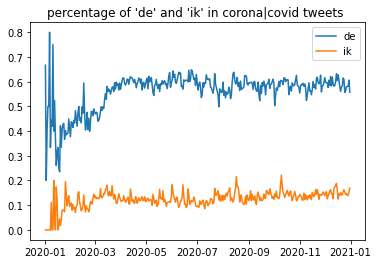

In [30]:
DATE_PATTERN = "%Y%m%d"

for word in ["de", "ik"]:
    x = []
    y = []
    for date in results[word]:
        if results[word][date][0] != 0:
            x.append(datetime.datetime.strptime(date, DATE_PATTERN))
            y.append(results[word][date][1]/results[word][date][0])
    plt.plot_date(x, y, fmt="-", label=word)

plt.title(f"percentage of 'de' and 'ik' in corona|covid tweets ")
plt.legend()
plt.show()

## Old code

In [ ]:
FILENAME202002 = "query-tokens-202002-202003.csv"
FILENAME202004 = "query-tokens-202004-202005.csv"
NON = "non-"
WEEKS = {"2020020[2-8]":"20200202","20200209|2020021[0-5]":"20200209","2020021[6-9]|2020022[0-2]":"20200216","2020022[3-9]":"20200223",\
         "2020030[1-7]":"20200301","2020030[89]|2020031[0-4]":"20200308","2020031[5-9]|2020032[01]":"20200315","2020032[2-8]":"20200322",\
                                   "20200329|20200330|2020040[1-4]":"20200329",\
         "2020040[5-9]|2020041[01]":"20200405","2020041[2-8]":"20200412","20200419|2020042[0-5]":"20200419","2020042[6-9]|2020043|2020050[1-2]":"20200426",\
         "2020050[3-9]":"20200503","2020051[0-6]":"20200510","2020051[7-9]|2020052[0-3]":"20200517"}

In [ ]:
queryTokens202002 = readData(FILENAME202004)
nonQueryTokens202002 = readData(NON+FILENAME202004)
tscoresDataQuery = {}
tscoresDataNonQuery = {}
tscores = {}
for query in queryTokens202002:
    tscoresDataQuery[query] = makeTscoreData(combineInitialHashAt(queryTokens202002[query]))
    tscoresDataNonQuery[query] = makeTscoreData(combineInitialHashAt(nonQueryTokens202002[query]))
    print(query)
    tscores[query] = sortTscores(tscore.computeTscore(tscoresDataQuery[query],tscoresDataNonQuery[query]))
    for x in dictTopN(tscores[query]): print(round(x[0],1),x[1])

In [ ]:
# writeData(tscores,"tscores-202004-202005.csv")

In [ ]:
tscores202002 = readData("tscores-202002-202003.csv")
tscores202004 = readData("tscores-202004-202005.csv")

In [ ]:
TOPICS = "maatregelen mondkapje anderhalve besmet rivm ".split()

data = {}
for topic in TOPICS:
    for date in tscores202002.keys():
        if not topic in data: data[topic] = {}
        data[topic][date] = tscores202002[date][topic]
    for date in tscores202004.keys():
        data[topic][date] = tscores202004[date][topic]

In [ ]:
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter

DATEFORMAT = "%Y%m%d"

fig,ax = plt.subplots(figsize=(8,4))
ax.xaxis.set_major_formatter(DateFormatter("%d %b"))
for topic in TOPICS:
    plt.plot_date([datetime.strptime(WEEKS[date],DATEFORMAT) for date in data[topic]],list(data[topic].values()),label=topic,fmt="-")
ax.set(xlabel="date (weeks)",ylabel="t-scores")
plt.title("t-scores for relevant words, comparing selected topic tweets with unselected tweets")
plt.legend()
plt.show()

**Note**: We expected only positive scores for topic words but the graph shows that *anderhalve* had negative scores  in two weeks. This means that most of the tweets containing this word are outside our topic tweets. We checked a sample of these missing tweets and most of them turned out to be on-topic, but they lacked the words *corona* and *covid*.

In [ ]:
data["anderhalve"]

In [ ]:
for date in tscores202002: 
    print("#####",date)
    for x in dictTopN(sortTscores(tscores202002[date]),n=50): print(round(x[0],1),x[1])
for date in tscores202004:
    print("#####",date)
    for x in dictTopN(sortTscores(tscores202004[date]),n=50): print(round(x[0],1),x[1])

In [ ]:
queryTokens202004 = readData(FILENAME202004)
nonQueryTokens202004 = readData(NON+FILENAME202004)
for query in queryTokens202004:
    tscoresDataQuery[query] = makeTscoreData(combineInitialHashAt(queryTokens202004[query]))
    tscoresDataNonQuery[query] = makeTscoreData(combineInitialHashAt(nonQueryTokens202004[query]))
    print(query)
    for x in dictTopN(sortTscores(tscore.computeTscore(tscoresDataQuery[query],tscoresDataNonQuery[query]))): print(round(x[0],1),x[1])

In [ ]:
#writeData(queryTokens,"query-tokens-202004-202005.csv")
#writeData(nonQueryTokens,"non-query-tokens-202004-202005.csv")

In [ ]:
query = "2020051[7-9]|2020052[0-3]"
for x in dictTopN(sortTscores(tscore.computeTscore(tscoresDataQuery[query],tscoresDataNonQuery[query])),n=40): print(round(x[0],1),x[1])

In [ ]:
FILEPATTERN = "20200601" 
QUERY= r"1.5m|1,5m|afstand.*hou|hou.*afstand|anderhalve"

queryTokens = {}
nonQueryTokens = {}
tscoresDataQuery = {}
tscoresDataNonQuery = {}
queryTokens[FILEPATTERN],nonQueryTokens[FILEPATTERN] = getTokensOfMatchedTweets(FILEPATTERN,QUERY)
tscoresDataQuery[FILEPATTERN] = makeTscoreData(queryTokens[FILEPATTERN])
tscoresDataNonQuery[FILEPATTERN] = makeTscoreData(nonQueryTokens[FILEPATTERN])
for x in dictTopN(sortTscores(tscore.computeTscore(tscoresDataQuery[FILEPATTERN],tscoresDataNonQuery[FILEPATTERN])),n=40): 
    print(round(x[0],1),x[1])

**Note**: the query "zorg" produces many false positives. There are irrelevant types ("bezorgd" and "bezorgen"), irrelevant syntactical forms ("ik zorg dat" and "Zorg dat je") and even the correct sense is not always related to the pandemic topic ("zorg voor ouderen/gehandicapten").

## Estimate coverage of crawler by looking back for messages with replies

In [ ]:
DATEPATTERN = "20200522"

fileList = sorted(os.listdir(DATADIR))
seenIds = {}
for inFileName in fileList:
    if re.search(DATEPATTERN,inFileName):
        df = pd.read_csv(DATADIR+inFileName,compression="gzip",dtype=str)
        known = 0
        unknown = 0
        for i in range(0,len(df)):
            idstr = df.iloc[i][ID]
            seenIds[idstr] = True
            replyParent = df.iloc[i][REPLYID]
            if str(replyParent) != "nan":
                if replyParent in seenIds: known += 1
                else: unknown += 1
        print("{0} {1:.3f}".format(inFileName,round(known/(known+unknown),3)))